In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from mlptools.analyzer.symmetry_function import SymmetryFunctionValueReader

# 対称性関数の値を取得する

In [4]:
path2target = "/Users/y1u0d2/Google Drive/マイドライブ/HamaLab_kotani/n2p2/SiO2/02/sf/angular"
atom_num_symbol_map = {
    14: "Si",
    8: "O"
}

sf_reader = SymmetryFunctionValueReader(path2target)
sf_df_dict = sf_reader.read(
    atom_num_symbol_map=atom_num_symbol_map,
    number_of_sf_per_atom=288
)

All files exist
Si symmetry function columns are created
Symmetry function dataframe of Si is created
O symmetry function columns are created
Symmetry function dataframe of O is created


## 原子種ごとに相関係数を確認する

In [5]:
silicon_sf_df = sf_df_dict["Si"]
oxygen_sf_df = sf_df_dict["O"]

silicon_sf_df.to_csv(os.path.join(path2target, "Si_sf.csv"), index=False)
oxygen_sf_df.to_csv(os.path.join(path2target, "O_sf.csv"), index=False)

# 読み込む

In [67]:
path2target = "/Users/y1u0d2/Google Drive/マイドライブ/HamaLab_kotani/n2p2/SiO2/02/sf/radial"
is_radial = True

silicon_sf_df = pd.read_csv(os.path.join(path2target, "Si_sf.csv"))
oxygen_sf_df = pd.read_csv(os.path.join(path2target, "O_sf.csv"))

In [68]:
threshold = 0.97

def get_highly_correlated_features(corr_matrix, threshold):
    print(f"Number of features: {len(corr_matrix.columns.unique())}")
    cols_to_drop = []
    for i in range(len(corr_matrix)):
        for j in range(i+1, len(corr_matrix)):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[j]
                if colname not in cols_to_drop:
                    cols_to_drop.append(colname)
    print(f"Number of selected features: {len(corr_matrix.columns.unique()) - len(cols_to_drop)}")
    return cols_to_drop

def select_symmetry_functions(sf_df: pd.DataFrame, threshold: float):
    corr_matrix = sf_df.corr(method="pearson")
    cols_to_drop = get_highly_correlated_features(corr_matrix, threshold)
    return sf_df.drop(cols_to_drop, axis=1)

## Optional(結合ごとにdfを分ける)

In [70]:
from copy import deepcopy

def select_symmetry_functions_each_bond(sf_df: pd.DataFrame, threshold: float, is_radial: bool = False):
    idx_until_keyword_ends = 3 if is_radial else 4

    # get unique bond
    unique_bond = []
    for col in sf_df.columns:
        unique_bond.append("_".join(col.split("_")[:idx_until_keyword_ends]))

    unique_bond = list(set(unique_bond))

    # assign features to unique bond
    unique_bond_dict = {bond : [] for bond in unique_bond}
    for col in sf_df.columns:
        bond = "_".join(col.split("_")[:idx_until_keyword_ends])
        unique_bond_dict[bond].append(col)

    # select features for each unique bond
    selected_features = []
    for bond in unique_bond:
        print(f"features of {bond} being selected...")
        bond_df = select_symmetry_functions(
            sf_df = sf_df[unique_bond_dict[bond]],
            threshold = threshold
        )
        selected_features.extend(bond_df.columns.to_list())
    
    print(f"Number of selected features in total: {len(selected_features)}")
    
    return deepcopy(sf_df[selected_features])


selected_silicon_sf_df = select_symmetry_functions_each_bond(
    sf_df = silicon_sf_df,
    threshold = threshold,
    is_radial = is_radial
)
selected_oxygen_sf_df = select_symmetry_functions_each_bond(
    sf_df = oxygen_sf_df,
    threshold = threshold,
    is_radial = is_radial
)

features of Si_2_O being selected...
Number of features: 144
Number of selected features: 14
features of Si_2_Si being selected...
Number of features: 144
Number of selected features: 5
Number of selected features in total: 19
features of O_2_Si being selected...
Number of features: 144
Number of selected features: 14
features of O_2_O being selected...
Number of features: 144
Number of selected features: 4
Number of selected features in total: 18


In [39]:
# 結合は区別しない
# selected_silicon_sf_df = select_symmetry_functions(silicon_sf_df, threshold)
# selected_oxygen_sf_df = select_symmetry_functions(oxygen_sf_df, threshold)

Number of features: 216
Number of selected features: 7
Number of features: 216
Number of selected features: 9


# 選択された説明変数をinput.nnで使えるようにする

In [71]:
for col in selected_silicon_sf_df.columns.to_list() + selected_oxygen_sf_df.columns.to_list():
    print(f'symfunction_short {" ".join(col.split("_"))}')

symfunction_short Si 2 O 0.1111 0.0 3.0
symfunction_short Si 2 O 1.182 2.08 3.0
symfunction_short Si 2 O 1.467 2.174 3.0
symfunction_short Si 2 O 1.667 2.226 3.0
symfunction_short Si 2 O 2.458 1.442 3.0
symfunction_short Si 2 O 3.029 1.651 3.0
symfunction_short Si 2 O 18.18 0.674 3.0
symfunction_short Si 2 O 19.26 0.6 3.0
symfunction_short Si 2 O 33.03 0.5 3.0
symfunction_short Si 2 O 0.6647 2.773 4.0
symfunction_short Si 2 O 1.383 1.923 4.0
symfunction_short Si 2 O 3.096 1.633 4.0
symfunction_short Si 2 O 1.841 1.667 5.0
symfunction_short Si 2 O 2.501 1.817 6.0
symfunction_short Si 2 Si 0.1111 0.0 3.0
symfunction_short Si 2 Si 2.778 0.0 3.0
symfunction_short Si 2 Si 10.0 0.9086 3.0
symfunction_short Si 2 Si 18.18 0.674 3.0
symfunction_short Si 2 Si 33.03 0.5 3.0
symfunction_short O 2 Si 0.1111 0.0 3.0
symfunction_short O 2 Si 1.182 2.08 3.0
symfunction_short O 2 Si 1.467 2.174 3.0
symfunction_short O 2 Si 1.667 2.226 3.0
symfunction_short O 2 Si 2.458 1.442 3.0
symfunction_short O 2 S

# Heatmapで相関係数を確認する

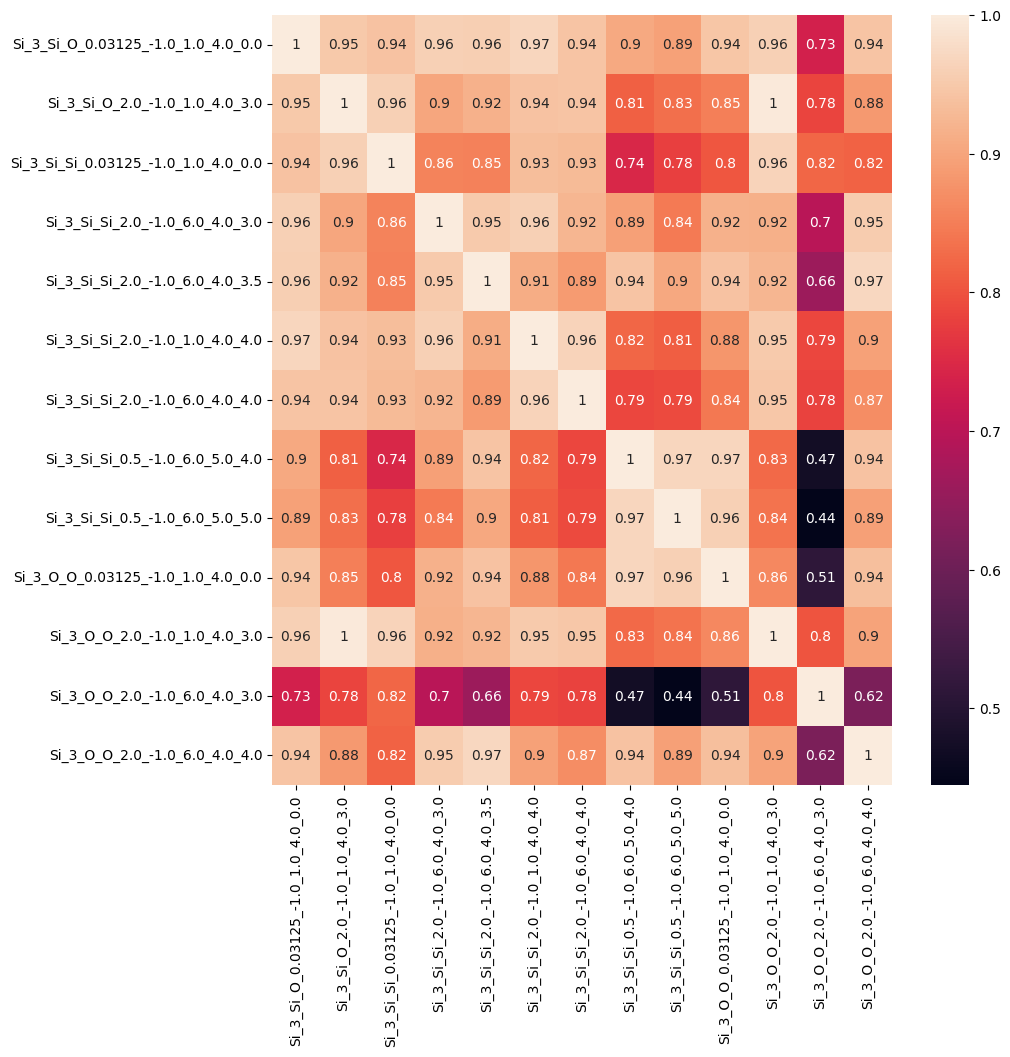

In [65]:
corr = selected_silicon_sf_df.corr(method="pearson")
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, ax=ax)
plt.show()

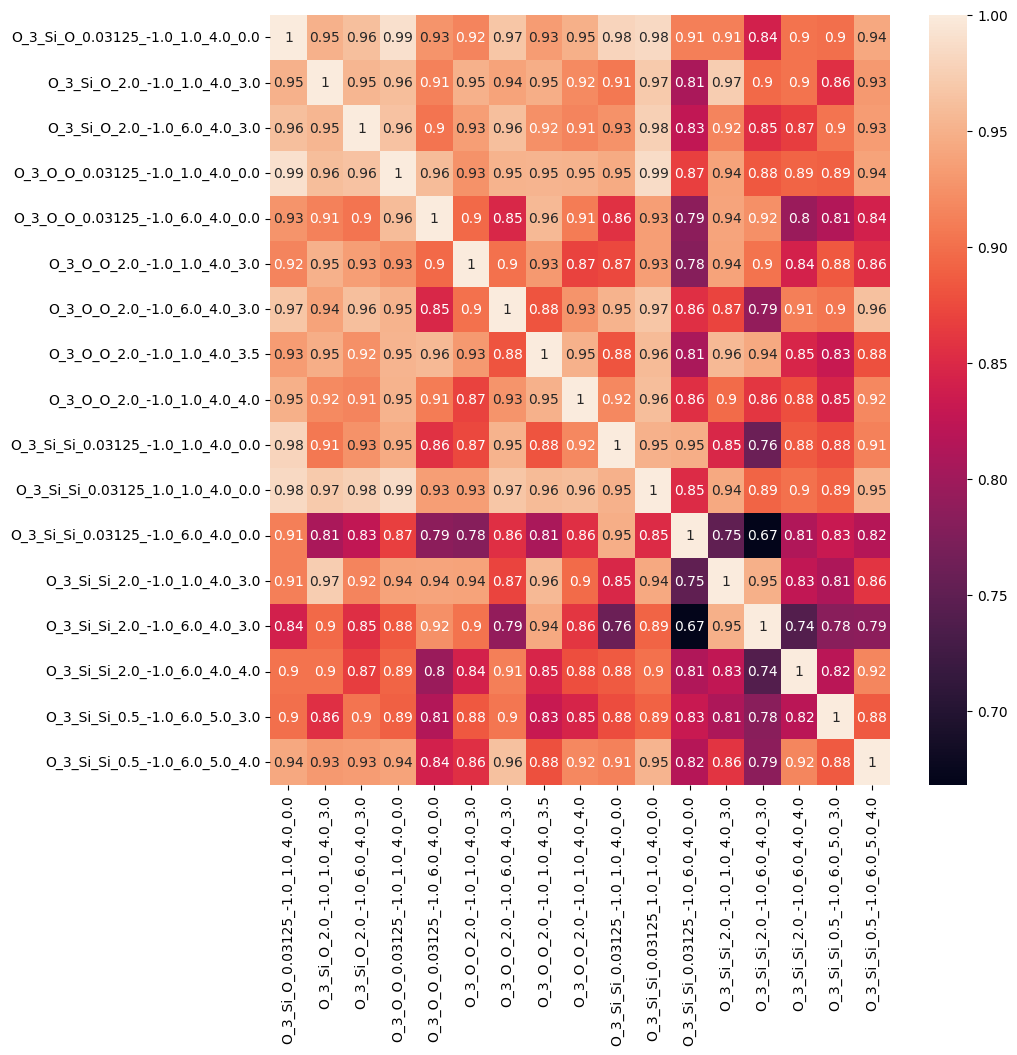

In [66]:
corr = selected_oxygen_sf_df.corr(method="pearson")
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, ax=ax)
plt.show()